In [14]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from calibrated_response.models.variable import ContinuousVariable
from calibrated_response.models.query import (
    ProbabilityEstimate,
    ExpectationEstimate,
    ConditionalProbabilityEstimate,
    ConditionalExpectationEstimate,
    InequalityProposition,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# with open("maxent_llm_cache_large.pkl", "wb") as f:
#     import pickle
#     pickle.dump((variables, estimates), f)
with open("maxent_llm_cache_large.pkl", "rb") as f:
    import pickle
    variables, estimates = pickle.load(f)

In [16]:
import jax
import jax.numpy as jnp

from calibrated_response.energy_models.markov_random import MarkovRandomField
from calibrated_response.energy_models.neural import NeuralEnergyModel

nn_model = NeuralEnergyModel(len(variables), hidden_sizes=[128, 128, 128])
params_pytree = nn_model.init_params(jax.random.PRNGKey(0))
params = nn_model.pack_params(params_pytree)
energy_fn = nn_model.energy_fn_flat
init_x = jnp.zeros(len(variables))  
energy_value = energy_fn(params, init_x)
print("Initial energy value:", energy_value)

Initial energy value: 0.0012600148


In [ ]:

mrf = MarkovRandomField.from_estimates(variables, estimates, clique_type='rbf')
# params_pytree = mrf.zero_params()
params_pytree = mrf.init_params(jax.random.PRNGKey(10))
params = mrf.pack_params(params_pytree)
energy_fn = mrf.energy_fn_flat
# init_x = jnp.array([2.0, 1.0])  # Initial guess for (gdp_growth, inflation_rate)
init_x = jnp.zeros(len(variables))  # Initial guess at the mean of the distribution
energy_value = energy_fn(params, init_x)
print(f"Energy at initial guess: {energy_value}")

Energy at initial guess: 3.6595988273620605


In [18]:
from calibrated_response.maxent_smm.distribution_builder import DistributionBuilder
from calibrated_response.maxent_smm.maxent_solver import JAXSolverConfig

config = JAXSolverConfig(
    num_chains=512,
    num_iterations=500,
    mcmc_steps_per_iteration=4,
    learning_rate=0.001,

    l2_regularization=1e-2,

    hmc_step_size=0.015,
    hmc_leapfrog_steps=10,
    max_bins=15,
    seed=42,
    verbose=True,
    continuous_prior="gaussian",
)

builder = DistributionBuilder(variables=variables, estimates=estimates, solver_config=config,
                              energy_fn=energy_fn, init_theta=params)

# Build for GDP growth (the solver trains once; marginals for all variables are in info)
distribution, info = builder.build(target_variable=variables[0].name)

print(f"\nConverged: {info['converged']}")
print(f"Features used: {info['n_features']}")
print(f"Skipped: {info['skipped_constraints']}")

Compiled maxent solver
[MaxEntSolver] iter   50  max_err=0.646677  mean_err=0.087832  mean_squared_err=0.014543  accept=0.670  step_size=0.08537
[MaxEntSolver] iter  100  max_err=0.798358  mean_err=0.066111  mean_squared_err=0.009408  accept=0.660  step_size=0.08863
[MaxEntSolver] iter  150  max_err=0.778059  mean_err=0.066322  mean_squared_err=0.009222  accept=0.624  step_size=0.09202
[MaxEntSolver] iter  200  max_err=0.784272  mean_err=0.063636  mean_squared_err=0.009063  accept=0.623  step_size=0.08644
[MaxEntSolver] iter  250  max_err=0.776370  mean_err=0.065467  mean_squared_err=0.009458  accept=0.646  step_size=0.08974
[MaxEntSolver] iter  300  max_err=0.792765  mean_err=0.061784  mean_squared_err=0.008500  accept=0.673  step_size=0.09317
[MaxEntSolver] iter  350  max_err=0.769385  mean_err=0.063858  mean_squared_err=0.008946  accept=0.622  step_size=0.08752
[MaxEntSolver] iter  400  max_err=0.777512  mean_err=0.062014  mean_squared_err=0.008622  accept=0.667  step_size=0.09086
[

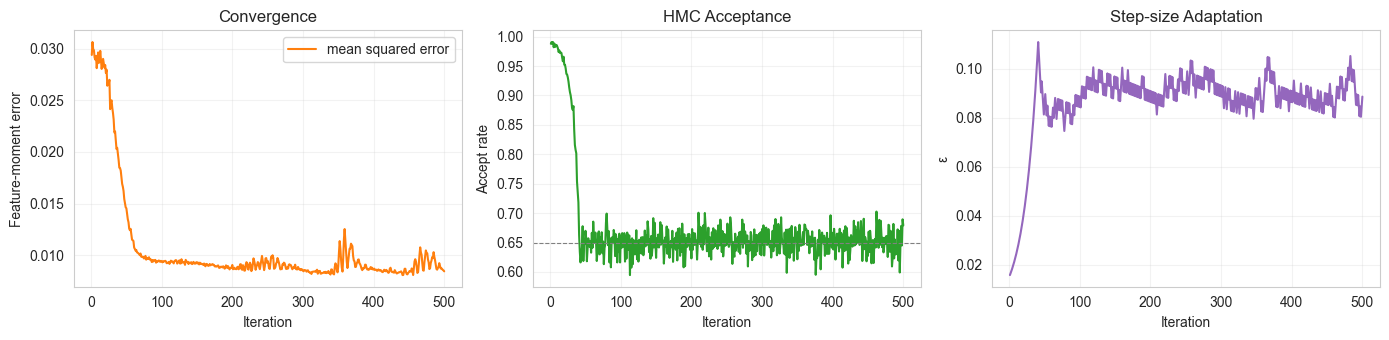

Final max error:  0.77344
Final mean error: 0.06115
Final accept rate: 0.679


In [19]:
history = info["history"]

fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))

# axes[0].plot(history["iteration"], history["max_error"], label="max error", color="C3")
# axes[0].plot(history["iteration"], history["mean_error"], label="mean error", color="C0")
axes[0].plot(history["iteration"], history["mean_squared_error"], label="mean squared error", color="C1")

axes[0].set_xlabel("Iteration"); axes[0].set_ylabel("Feature-moment error")
axes[0].set_title("Convergence"); axes[0].legend(); axes[0].grid(alpha=0.25)

axes[1].plot(history["iteration"], history["accept_rate"], color="C2")
axes[1].axhline(config.target_accept_rate, ls="--", color="gray", lw=0.8)
axes[1].set_xlabel("Iteration"); axes[1].set_ylabel("Accept rate")
axes[1].set_title("HMC Acceptance"); axes[1].grid(alpha=0.25)

axes[2].plot(history["iteration"], history["step_size"], color="C4")
axes[2].set_xlabel("Iteration"); axes[2].set_ylabel("ε")
axes[2].set_title("Step-size Adaptation"); axes[2].grid(alpha=0.25)

plt.tight_layout(); plt.show()

print(f"Final max error:  {history['max_error'][-1]:.5f}")
print(f"Final mean error: {history['mean_error'][-1]:.5f}")
print(f"Final accept rate: {history['accept_rate'][-1]:.3f}")

In [21]:
feature_means = builder.solver._batch_feature_fn(info['chain_states']).mean(axis=0)
feature_targets = builder.feature_targets
error = feature_means - jnp.array(feature_targets)
el = list(zip(error, estimates))
el.sort(key=lambda x: abs(x[0]), reverse=True)
for i, (err, est) in enumerate(el):
    print(f"{i+1}. {est.to_query_estimate()}: error = {err:.4f}")

# print("\nFeature means under the distribution:")
# for i, feature in enumerate(estimates):
#     feature_name = feature.to_query_estimate()
#     print(f"  {feature_name}: {feature_means[i]:.4f}")
#     print(f"    target: {feature_targets[i]:.4f}, error: {error[i]:.4f}")


1. P(ai_bubble_bursts_by_2030 = True | annual_ai_software_revenue < 300000000000.0) = 0.85: error = -0.7734
2. E[training_cost_sota_model | llm_performance_plateau = True] = 5000000000.0: error = -0.4142
3. E[fortune500_ai_adoption_rate | global_recession_occurs = True] = 65.0: error = -0.3327
4. P(ai_job_displacement_rate > 5.0 | fortune500_ai_adoption_rate > 75.0) = 0.75: error = -0.2969
5. E[training_cost_sota_model] = 1000000000.0: error = 0.2085
6. P(annual_ai_software_revenue > 1000000000000.0 | ai_bubble_bursts_by_2030 = False) = 0.7: error = -0.1821
7. P(ai_bubble_bursts_by_2030 = True | llm_performance_plateau = True) = 0.7: error = 0.1684
8. E[ai_global_energy_share | training_cost_sota_model > 2000000000.0] = 7.0: error = -0.1667
9. P(llm_performance_plateau = True) = 0.6: error = -0.1643
10. P(ai_bubble_bursts_by_2030 = True | us_china_chip_conflict = True) = 0.5: error = 0.1628
11. E[ai_global_energy_share] = 3.5: error = 0.1589
12. P(us_china_chip_conflict = True | market

In [22]:
energy_model = info["energy_model"]
samples = energy_model.sample(n_samples=2000)

0: ai_bubble_bursts_by_2030: mean=0.474, std=0.324
1: annual_ai_software_revenue: mean=0.406, std=0.237
2: agi_breakthrough_achieved: mean=0.161, std=0.158
3: major_ai_safety_incident: mean=0.357, std=0.268
4: annual_vc_investment_ai: mean=0.245, std=0.180
5: llm_performance_plateau: mean=0.444, std=0.304
6: fortune500_ai_adoption_rate: mean=0.608, std=0.224
7: market_cap_top_ai_companies: mean=0.329, std=0.198
8: strict_ai_regulation_passed: mean=0.653, std=0.264
9: training_cost_sota_model: mean=0.239, std=0.170
10: ai_job_displacement_rate: mean=0.192, std=0.149
11: major_ai_company_failure: mean=0.322, std=0.261
12: global_recession_occurs: mean=0.540, std=0.288
13: us_china_chip_conflict: mean=0.430, std=0.280
14: ai_global_energy_share: mean=0.226, std=0.164


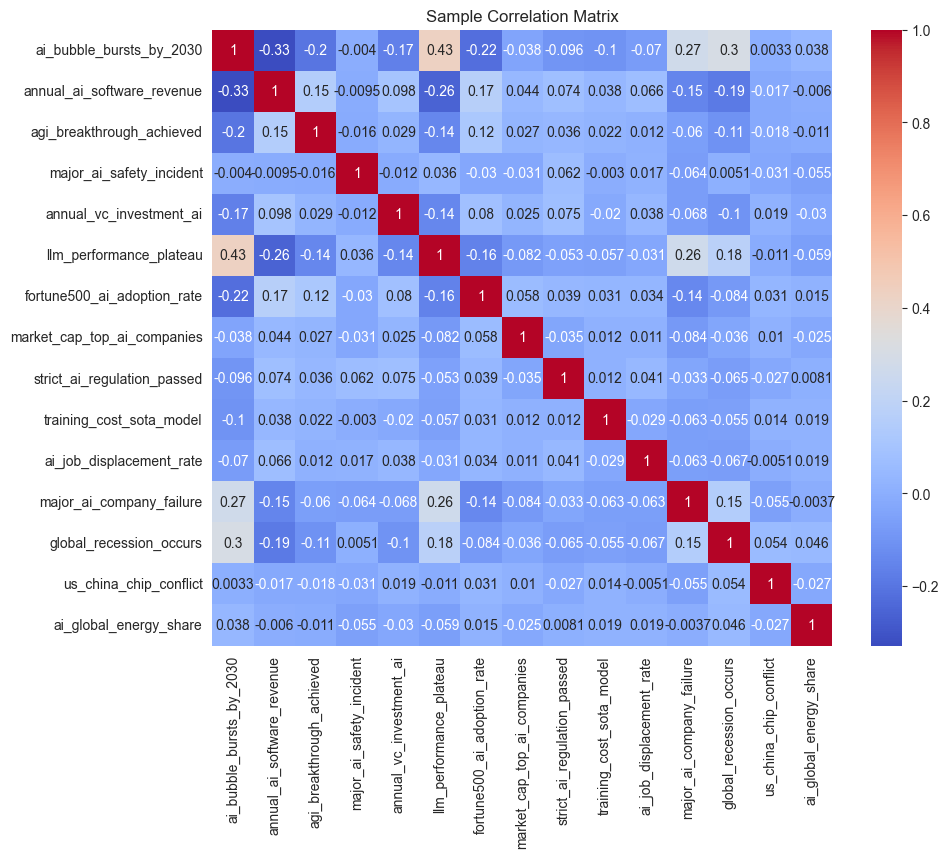

In [23]:
#calculate sample correlation matrix and plot as heatmap
import seaborn as sns
sns.set_style("whitegrid")
import jax.numpy as jnp
for i, var in enumerate(variables):
    print(f"{i}: {var.name}: mean={jnp.mean(samples[:, i]):.3f}, std={jnp.std(samples[:, i]):.3f}")

# Calculate sample correlation matrix
corr_matrix = jnp.corrcoef(samples, rowvar=False)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, xticklabels=[var.name for var in variables],
            yticklabels=[var.name for var in variables], cmap="coolwarm", annot=True)
plt.title("Sample Correlation Matrix")
plt.show()

In [24]:
corr_val = [(corr_matrix[i, j], variables[i].name, variables[j].name) for i in range(len(variables)) for j in range(i+1, len(variables))]
corr_val.sort(key=lambda x: abs(x[0]), reverse=True)
print("\nTop variable correlations:")
for corr, var1, var2 in corr_val[:10]:
    print(f"{var1} and {var2}: correlation = {corr:.3f}")


Top variable correlations:
ai_bubble_bursts_by_2030 and llm_performance_plateau: correlation = 0.433
ai_bubble_bursts_by_2030 and annual_ai_software_revenue: correlation = -0.328
ai_bubble_bursts_by_2030 and global_recession_occurs: correlation = 0.304
ai_bubble_bursts_by_2030 and major_ai_company_failure: correlation = 0.269
llm_performance_plateau and major_ai_company_failure: correlation = 0.264
annual_ai_software_revenue and llm_performance_plateau: correlation = -0.257
ai_bubble_bursts_by_2030 and fortune500_ai_adoption_rate: correlation = -0.223
ai_bubble_bursts_by_2030 and agi_breakthrough_achieved: correlation = -0.203
annual_ai_software_revenue and global_recession_occurs: correlation = -0.185
llm_performance_plateau and global_recession_occurs: correlation = 0.176



Top variable correlations:
ai_bubble_bursts_by_2030 and llm_performance_plateau: correlation = 0.439
ai_bubble_bursts_by_2030 and global_recession_occurs: correlation = 0.343
llm_performance_plateau and global_recession_occurs: correlation = 0.293
ai_bubble_bursts_by_2030 and annual_ai_software_revenue: correlation = -0.287
annual_ai_software_revenue and llm_performance_plateau: correlation = -0.268
ai_bubble_bursts_by_2030 and fortune500_ai_adoption_rate: correlation = -0.230
llm_performance_plateau and fortune500_ai_adoption_rate: correlation = -0.192
llm_performance_plateau and major_ai_company_failure: correlation = 0.178
fortune500_ai_adoption_rate and global_recession_occurs: correlation = -0.174
ai_bubble_bursts_by_2030 and major_ai_company_failure: correlation = 0.172


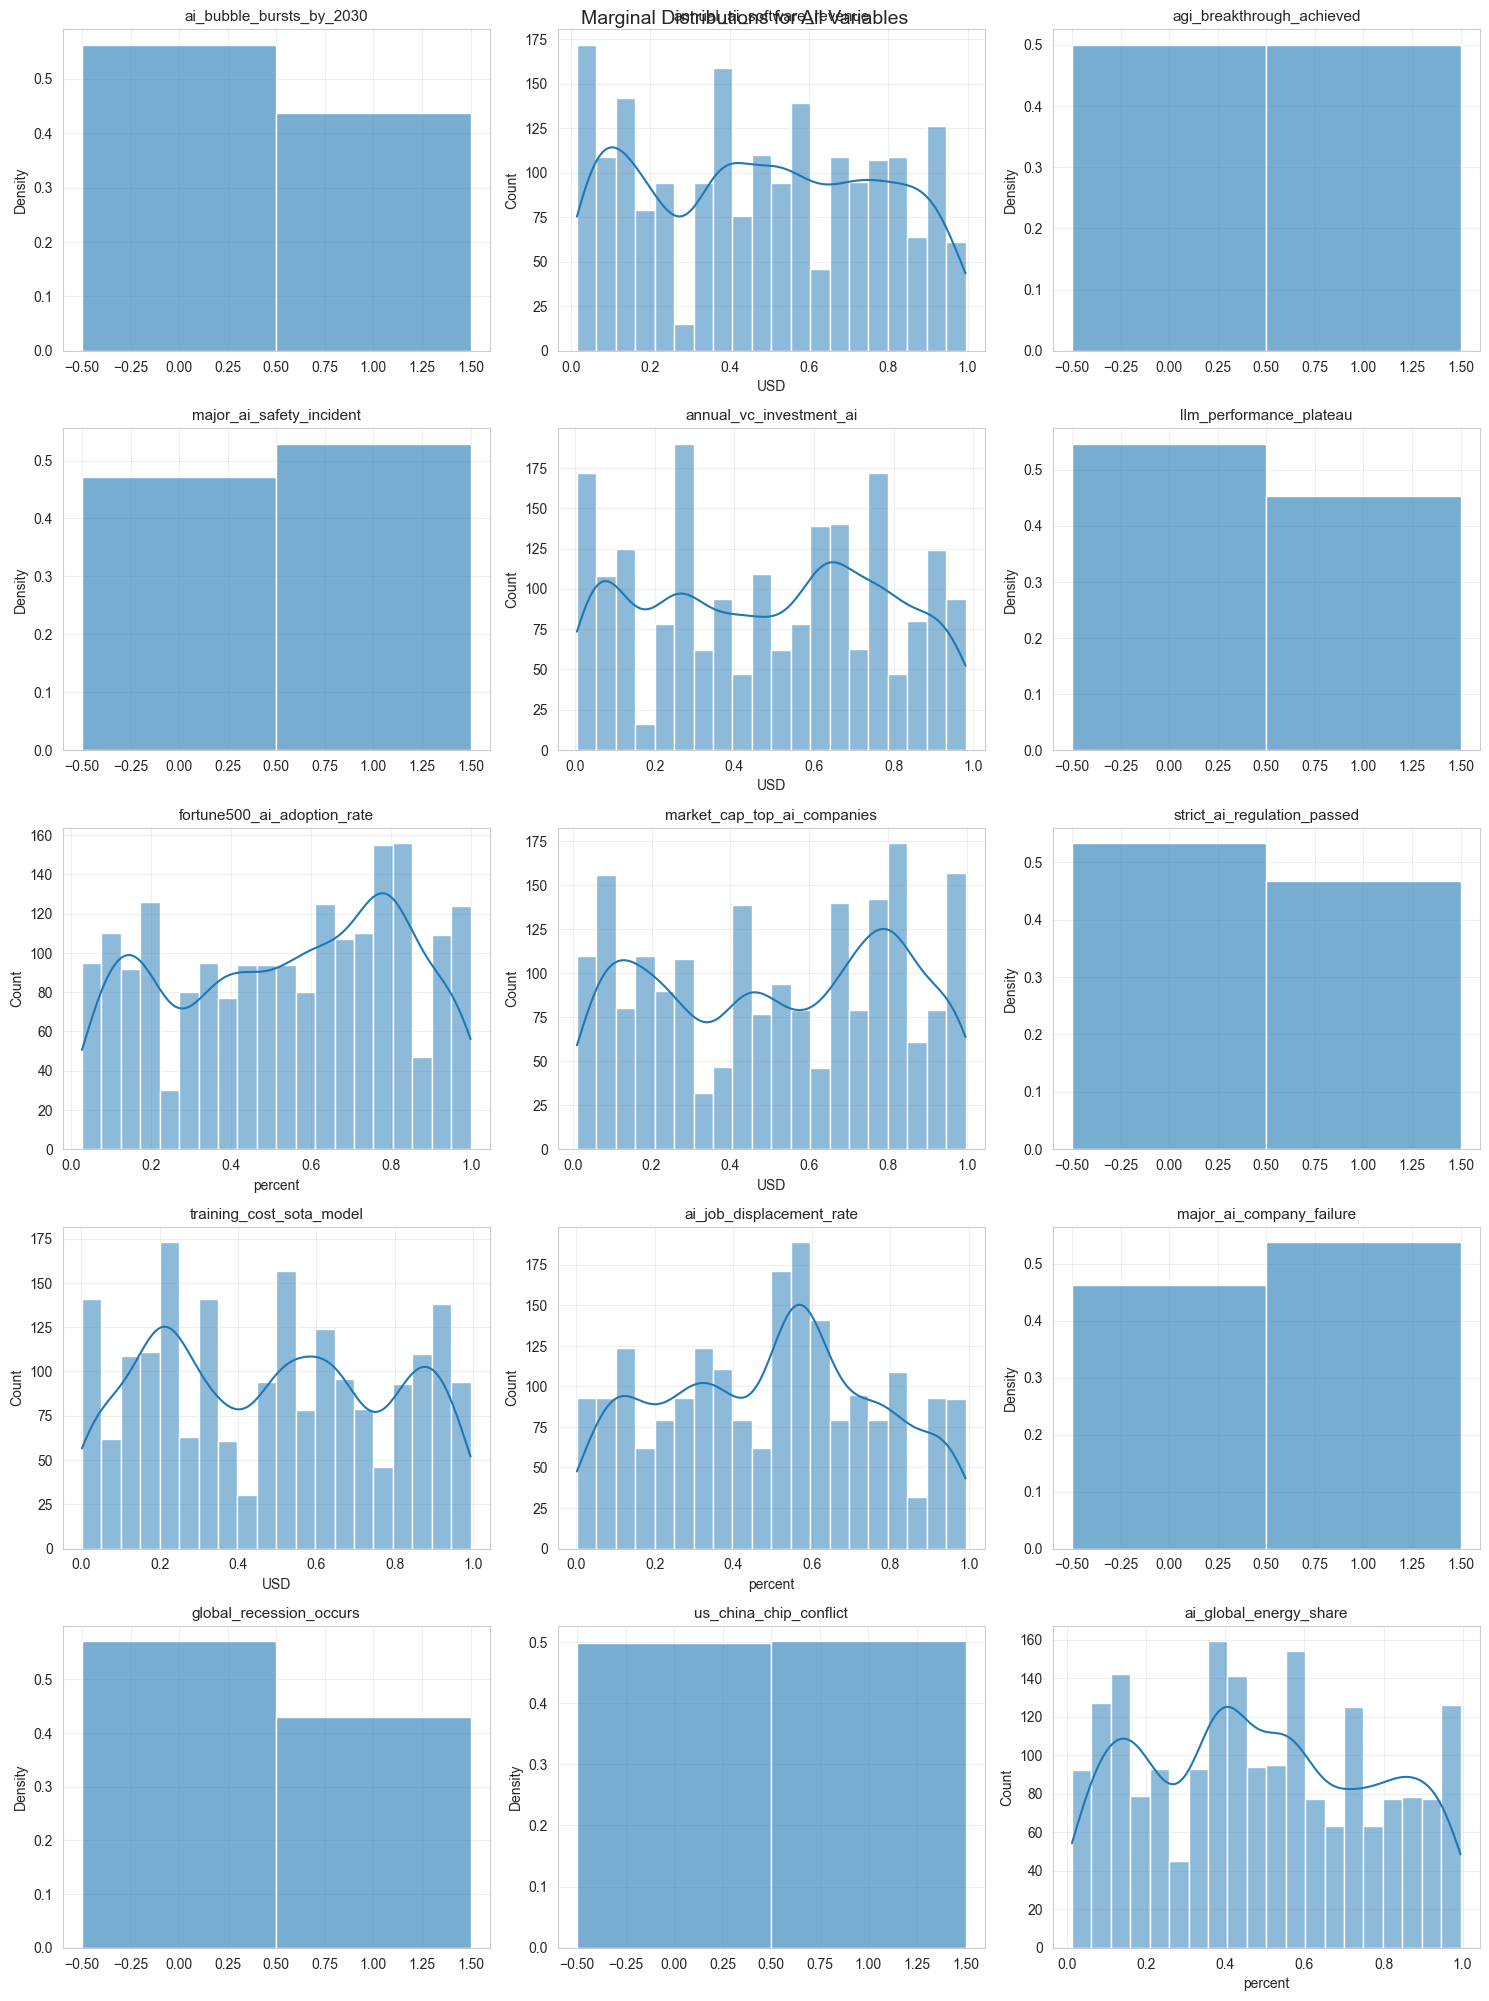

In [13]:
import seaborn as sns
from calibrated_response.models.variable import VariableType

# Plot all marginals in a grid
n_vars = len(variables)
n_cols = min(3, n_vars)
n_rows = (n_vars + n_cols) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_vars == 1:
    axes = [axes]
else:
    axes = axes.flatten()
    
for idx, var in enumerate(variables):
    if variables[idx].type == VariableType.BINARY:
        sns.histplot(samples[:, idx], bins=[-0.5, 0.5, 1.5], ax=axes[idx], color="C0", alpha=0.6, stat="density")
    else:
        sns.histplot(samples[:, idx], bins=20, kde=True, ax=axes[idx], color="C0")
        
    axes[idx].set_title(var.name, fontsize=11)
    axes[idx].set_xlabel(getattr(var, 'unit', '') or '', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_vars, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Marginal Distributions for All Variables', fontsize=14)
plt.tight_layout()
plt.show()

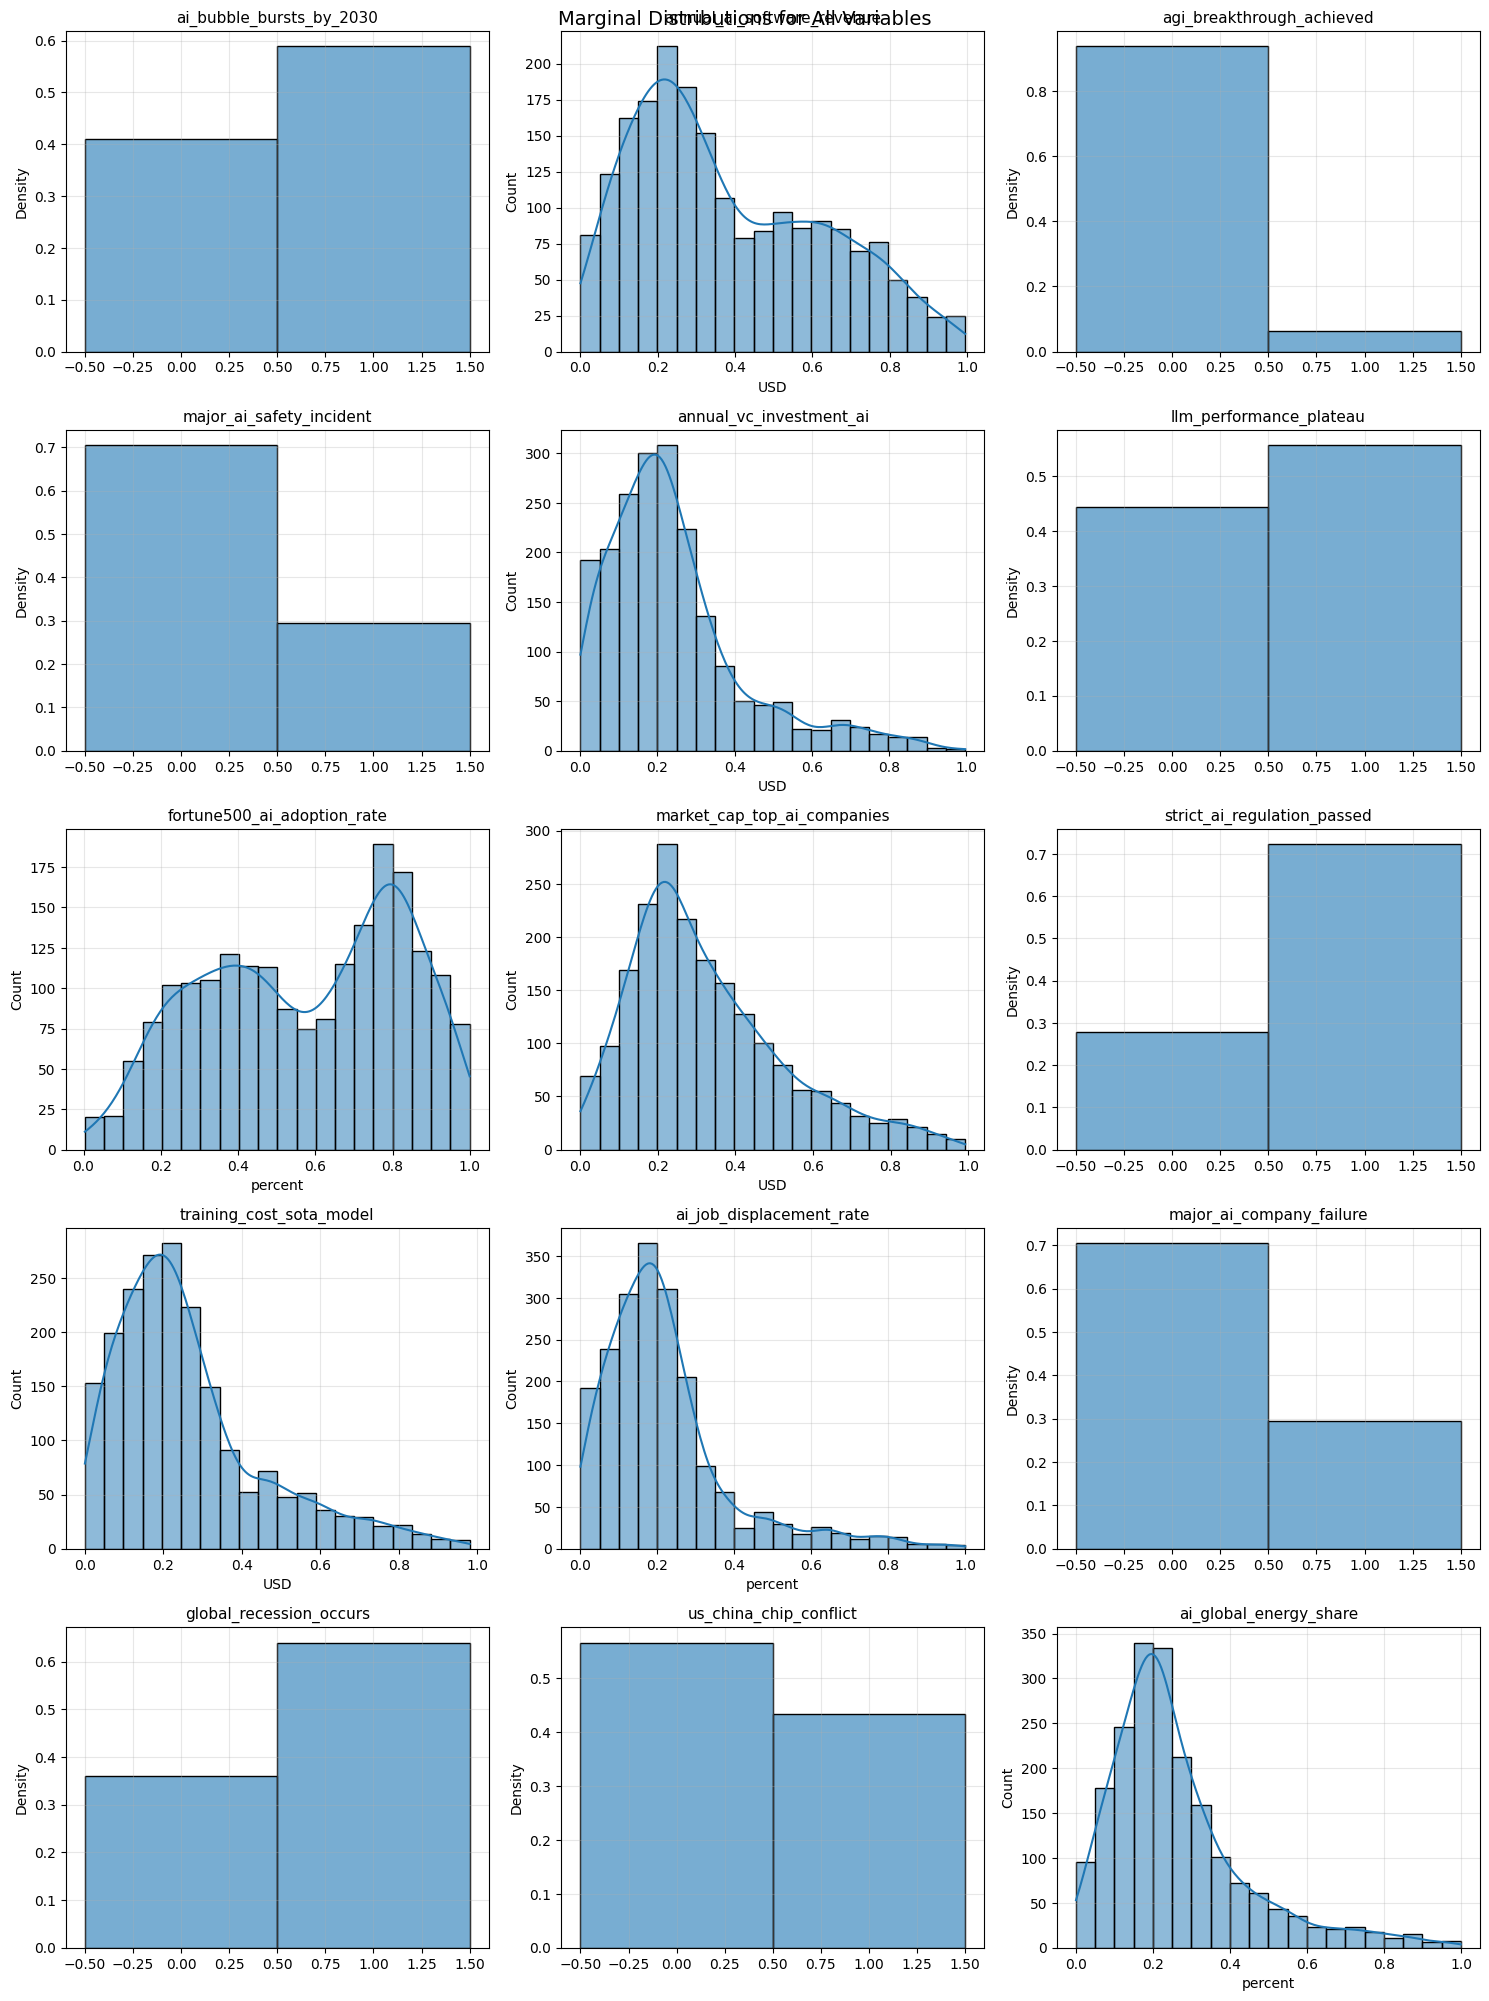

In [9]:
import jax.numpy as jnp
for i, var in enumerate(variables):
    print(f"{i}: {var.name}: mean={jnp.mean(samples[:, i]):.3f}, std={jnp.std(samples[:, i]):.3f}")

0: ai_bubble_bursts_by_2030: mean=0.572, std=0.336
1: annual_ai_software_revenue: mean=0.382, std=0.245
2: agi_breakthrough_achieved: mean=0.192, std=0.174
3: major_ai_safety_incident: mean=0.384, std=0.264
4: annual_vc_investment_ai: mean=0.242, std=0.180
5: llm_performance_plateau: mean=0.555, std=0.330
6: fortune500_ai_adoption_rate: mean=0.574, std=0.256
7: market_cap_top_ai_companies: mean=0.328, std=0.200
8: strict_ai_regulation_passed: mean=0.633, std=0.262
9: training_cost_sota_model: mean=0.265, std=0.194
10: ai_job_displacement_rate: mean=0.220, std=0.168
11: major_ai_company_failure: mean=0.378, std=0.268
12: global_recession_occurs: mean=0.606, std=0.299
13: us_china_chip_conflict: mean=0.468, std=0.281
14: ai_global_energy_share: mean=0.262, std=0.178


Text(0.5, 1.0, 'Joint Distribution of annual_ai_software_revenue and training_cost_sota_model')

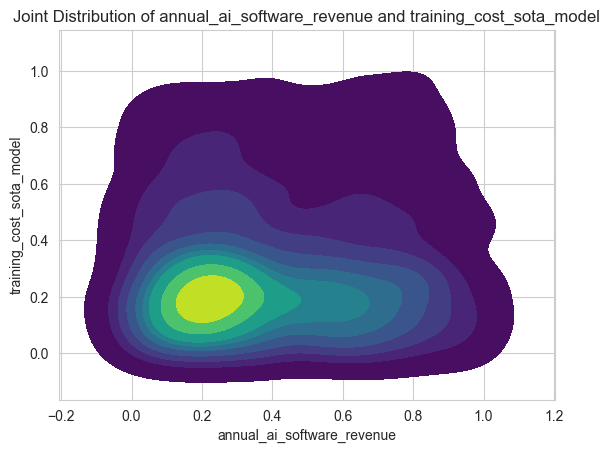

In [18]:
import seaborn as sns
sns.set_style("whitegrid")
# samples = samples[::5, :]
i1, i2 = 1, 9
sns.kdeplot(x=samples[:, i1], y=samples[:, i2], fill=True, 
            thresh=0.01, cmap="viridis")
plt.xlabel(variables[i1].name)
plt.ylabel(variables[i2].name)
plt.title(f"Joint Distribution of {variables[i1].name} and {variables[i2].name}")